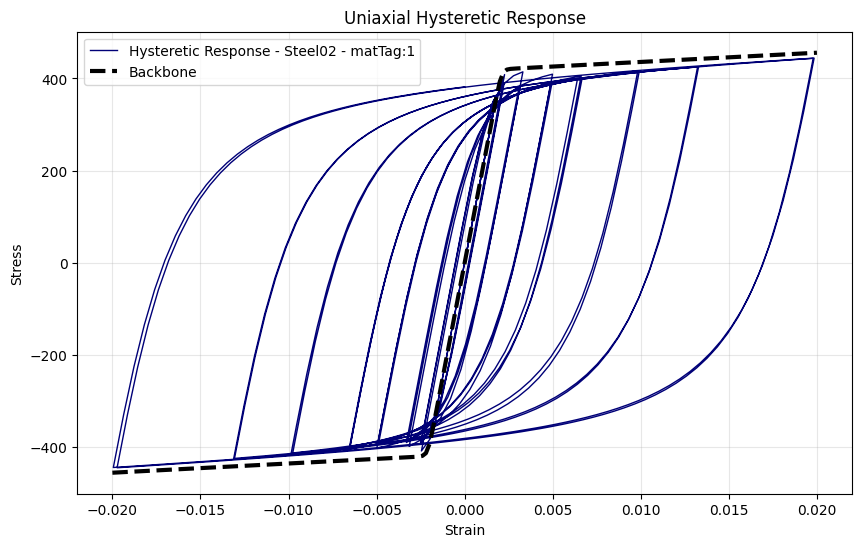

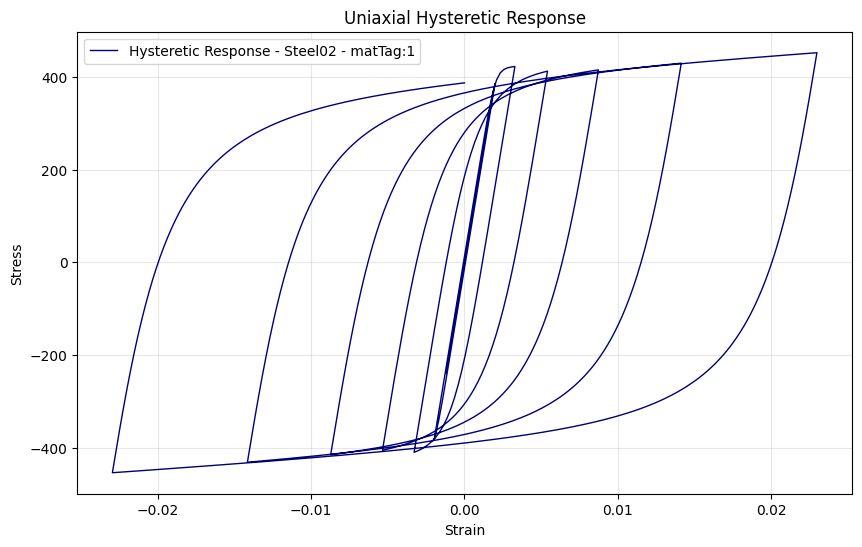

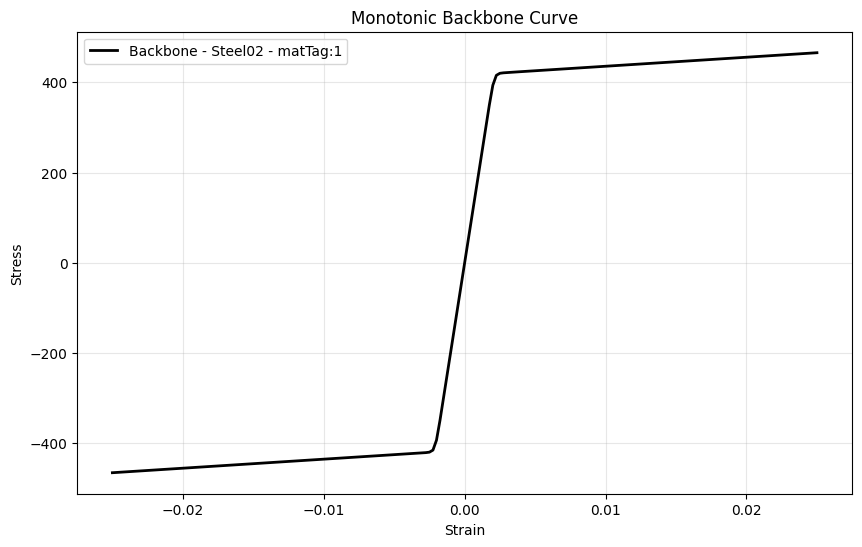

MaterialTestResult(points=1001, converged=True, peak_stress=445.04, energy=1.33e+02)
Help on MaterialTestResult in module apeSees.materials.results object:

class MaterialTestResult(builtins.object)
 |  MaterialTestResult(strain: 'np.ndarray', stress: 'np.ndarray', time: 'np.ndarray', converged: 'bool', material_tag: 'int' = 0, protocol_name: 'Optional[str]' = None, metadata: 'dict' = <factory>) -> None
 |  
 |  Results from a uniaxial material test analysis.
 |  
 |  Attributes
 |  ----------
 |  strain : np.ndarray
 |      Array of strain values.
 |  stress : np.ndarray
 |      Array of stress values.
 |  time : np.ndarray
 |      Normalized analysis time (0 to 1).
 |  converged : bool
 |      Whether the analysis converged successfully.
 |  material_tag : int, optional
 |      OpenSees material tag used in the test.
 |  protocol_name : str, optional
 |      Name of the loading protocol used.
 |  metadata : dict, optional
 |      Additional metadata about the test.
 |  
 |  Examples


In [10]:
import re
from apeSees.materials import Material
import matplotlib.pyplot as plt

# Create material
steel = Material("Steel02", 1, 420.0, 200000.0, 0.01, 20.0, 0.925, 0.15)

# Quick cyclic test with ASCE-41 protocol
ax, results = steel.cyclic_tester(max_strain=0.02)
plt.show()

# Try different protocol
ax, _ = steel.cyclic_tester(max_strain=0.03, protocol_type='fema461', show_backbone=False)
plt.show()

# Backbone only
ax, _ = steel.backbone_tester(max_strain=0.025)
plt.show()

print(results)
help(results)



Analysis converged: True
Peak stress: 445.04 MPa
Peak strain: 0.0199
Energy dissipated: 1.33e+02 J
Number of points: 1001
MaterialTestResult(points=1001, converged=True, peak_stress=445.04, energy=1.33e+02)


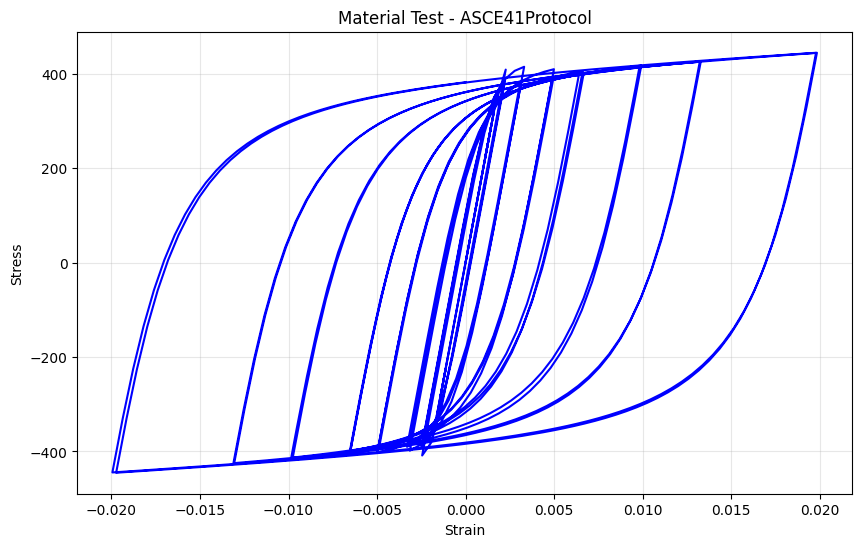

Result keys: dict_keys(['strain', 'stress', 'time', 'converged', 'material_tag', 'protocol_name', 'metadata'])


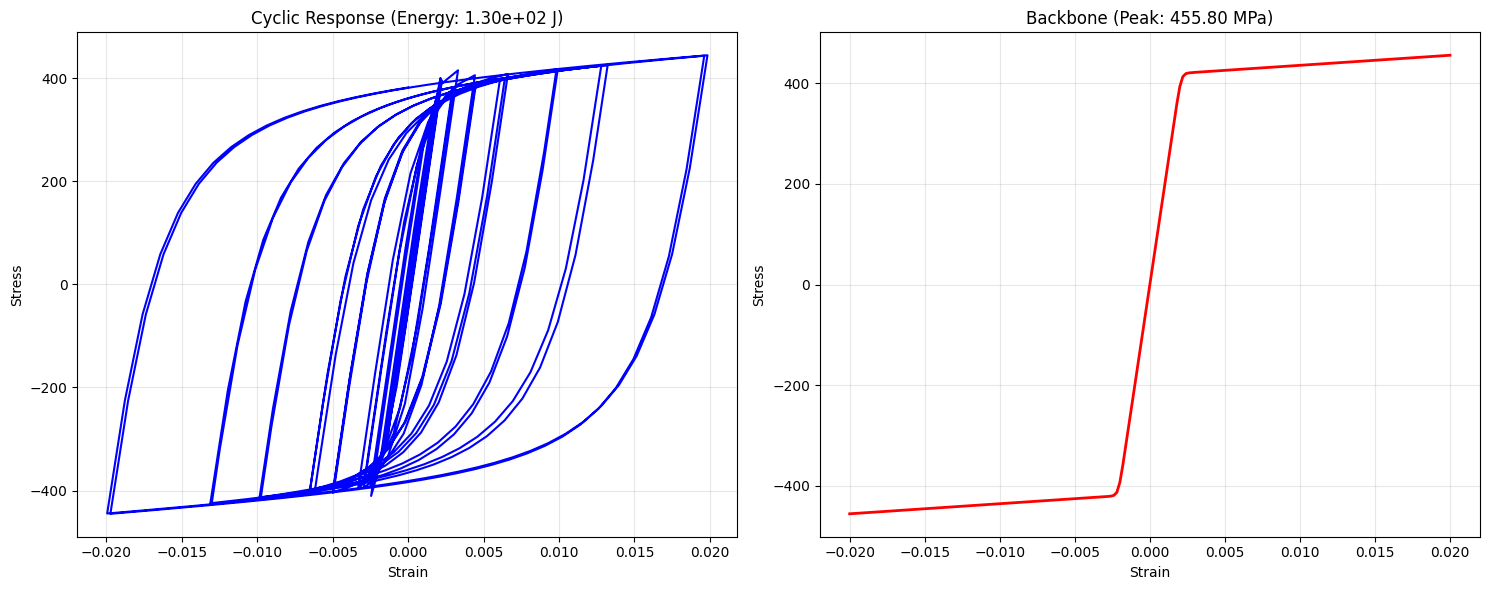

ASCE-41: Energy = 1.30e+02 J, Peak = 445.00 MPa
FEMA-461: Energy = 3.41e+01 J, Peak = 433.65 MPa


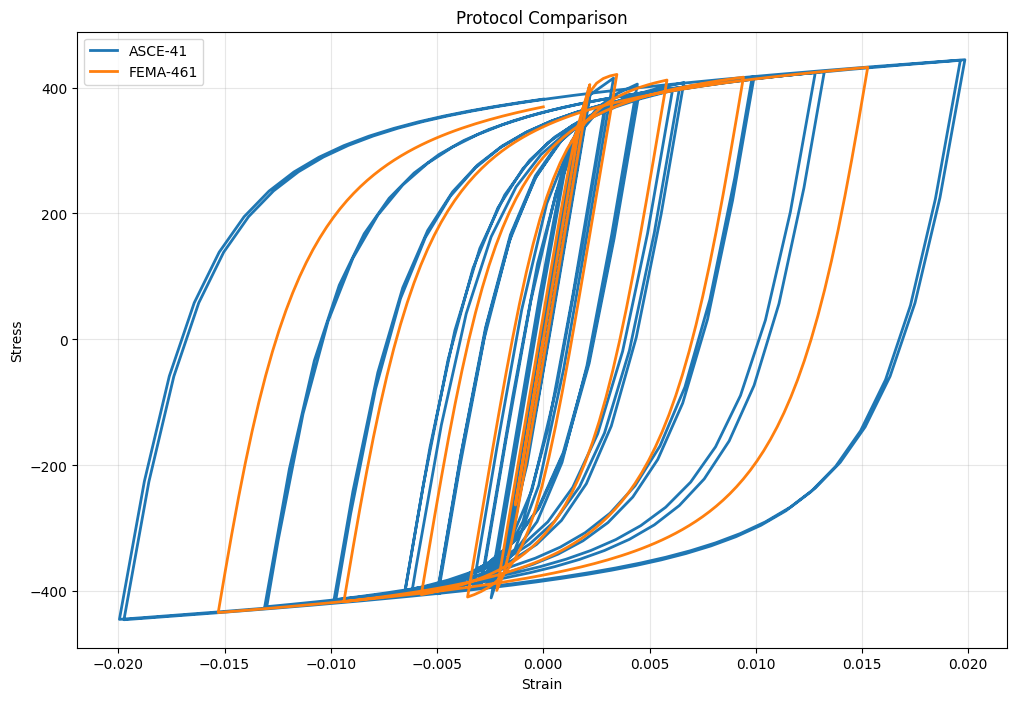

Custom protocol - Peak stress: 455.79 MPa


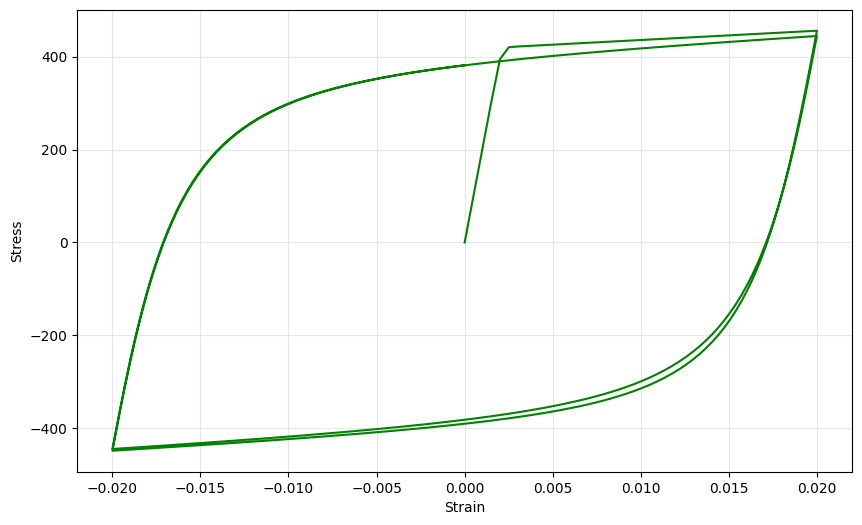

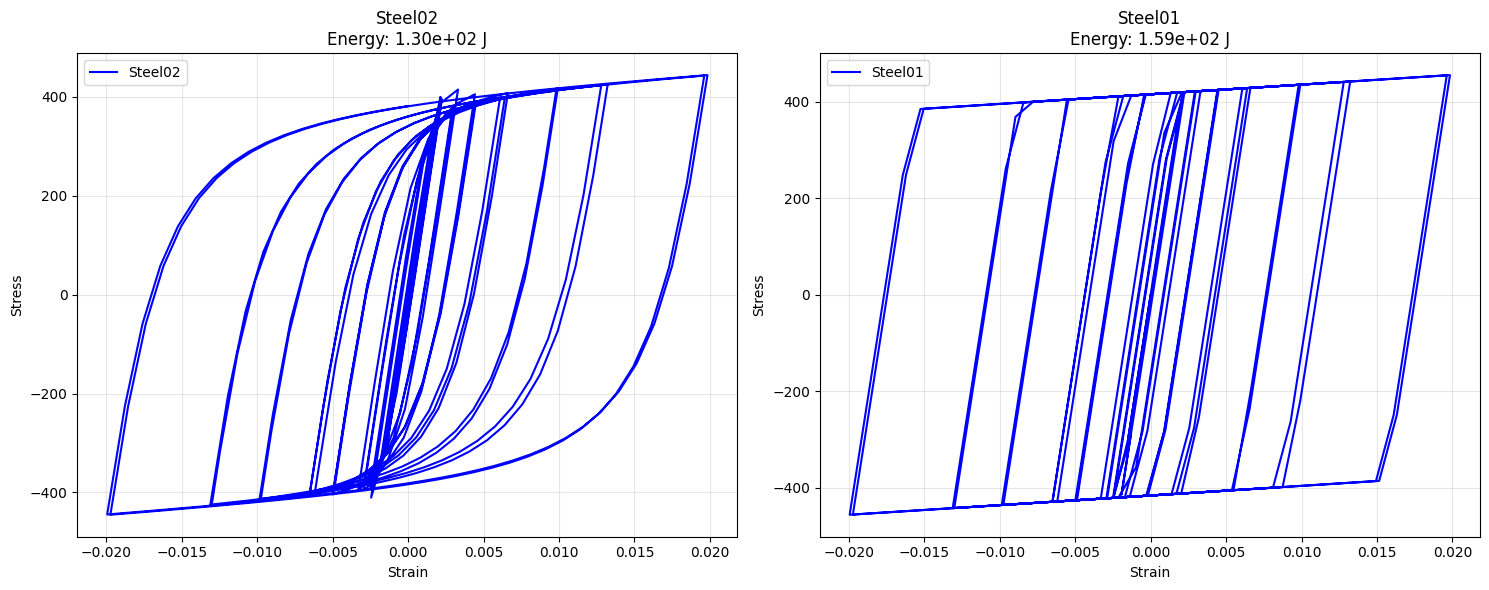

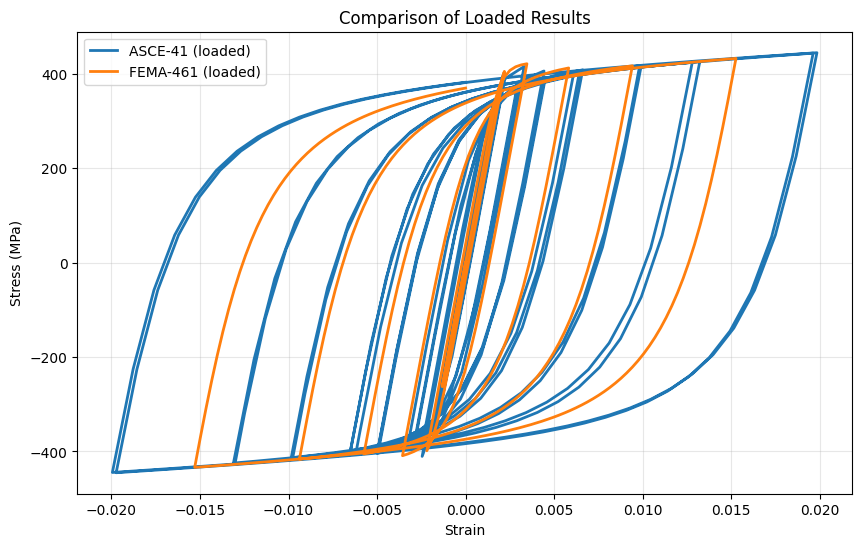

In [8]:
from apeSees.materials import Material
from apeSees.timeseries import ASCE41Protocol, FEMA461Protocol, PathTimeSeries
import matplotlib.pyplot as plt
import numpy as np

steel = Material("Steel02", 1, 420.0, 200000.0, 0.01, 20.0, 0.925, 0.15)

# Run analysis and get result object
protocol = ASCE41Protocol(tag=1, max_disp=0.02)
result = steel.tester.run(protocol, number_of_points=1000)

# Access result properties
print(f"Analysis converged: {result.converged}")
print(f"Peak stress: {result.peak_stress:.2f} MPa")
print(f"Peak strain: {result.peak_strain:.4f}")
print(f"Energy dissipated: {result.energy_dissipated:.2e} J")
print(f"Number of points: {result.num_points}")
print(result)  # Uses __repr__

# Save results for later
result.save('steel_asce41_test.npz')

# Load results
loaded_result = result.load('steel_asce41_test.npz')

# Plot using result object method
result.plot(label='ASCE-41', color='blue', linewidth=1.5)
plt.show()

# Export to dictionary (e.g., for JSON serialization)
data_dict = result.to_dict()
print(f"Result keys: {data_dict.keys()}")

# Custom plotting with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Hysteresis with result object
ax1, asce_result = steel.tester.plot(protocol, ax=ax1, label='ASCE-41', color='blue')
ax1.set_title(f'Cyclic Response (Energy: {asce_result.energy_dissipated:.2e} J)')

# Right: Backbone with result object
ax2, backbone_result = steel.tester.plot_backbone(
    strain_max=0.02,
    strain_min=-0.02,
    ax=ax2,
    label='Backbone',
    color='red',
    linewidth=2
)
ax2.set_title(f'Backbone (Peak: {backbone_result.peak_stress:.2f} MPa)')

plt.tight_layout()
plt.show()

# Compare protocols and collect results
protocols = [
    (ASCE41Protocol(tag=1, max_disp=0.02), 'ASCE-41'),
    (FEMA461Protocol(tag=2, max_disp=0.02), 'FEMA-461'),
]

# Run each protocol and store results
results = []
for ts, label in protocols:
    result = steel.tester.run(ts, number_of_points=500)
    results.append(result)
    print(f"{label}: Energy = {result.energy_dissipated:.2e} J, Peak = {result.peak_stress:.2f} MPa")

# Plot comparison
fig = steel.tester.compare_protocols(protocols, number_of_points=500)
plt.show()

# Custom time series with result analysis
custom_time = np.linspace(0, 1, 200)
custom_strain = 0.02 * np.sin(4 * np.pi * custom_time)
custom_ts = PathTimeSeries(tag=1, time=custom_time, values=custom_strain)

ax, custom_result = steel.tester.plot(custom_ts, label='Custom Loading', color='green')
print(f"Custom protocol - Peak stress: {custom_result.peak_stress:.2f} MPa")
plt.show()

# Advanced: Batch testing with multiple materials
materials = {
    'Steel02': Material("Steel02", 1, 420.0, 200000.0, 0.01, 20.0, 0.925, 0.15),
    'Steel01': Material("Steel01", 2, 420.0, 200000.0, 0.01),
}

protocol = ASCE41Protocol(tag=1, max_disp=0.02)
fig, axes = plt.subplots(1, len(materials), figsize=(15, 6))

for (name, mat), ax in zip(materials.items(), axes):
    result = mat.tester.run(protocol, number_of_points=500)
    result.plot(ax=ax, label=name, color='blue', linewidth=1.5)
    ax.set_title(f'{name}\nEnergy: {result.energy_dissipated:.2e} J')
    ax.legend()

plt.tight_layout()
plt.show()

# Save multiple results for comparison
for i, result in enumerate(results):
    result.save(f'protocol_comparison_{i}.npz')

# Load and compare later
loaded_results = [
    result.load('protocol_comparison_0.npz'),
    result.load('protocol_comparison_1.npz'),
]

fig, ax = plt.subplots(figsize=(10, 6))
for res, (_, label) in zip(loaded_results, protocols):
    ax.plot(res.strain, res.stress, label=f'{label} (loaded)', linewidth=2)
ax.set_xlabel('Strain')
ax.set_ylabel('Stress (MPa)')
ax.set_title('Comparison of Loaded Results')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


ASCE-41 Results:
  Converged: True
  Peak stress: 445.00 MPa
  Peak strain: 0.0199
  Energy dissipated: 1.30e+02 J

Modified ATC-24 Results:
  Converged: True
  Peak stress: 445.47 MPa
  Peak strain: 0.0200
  Energy dissipated: 9.74e+01 J

FEMA-461 Results:
  Converged: True
  Peak stress: 433.65 MPa
  Peak strain: 0.0153
  Energy dissipated: 3.41e+01 J


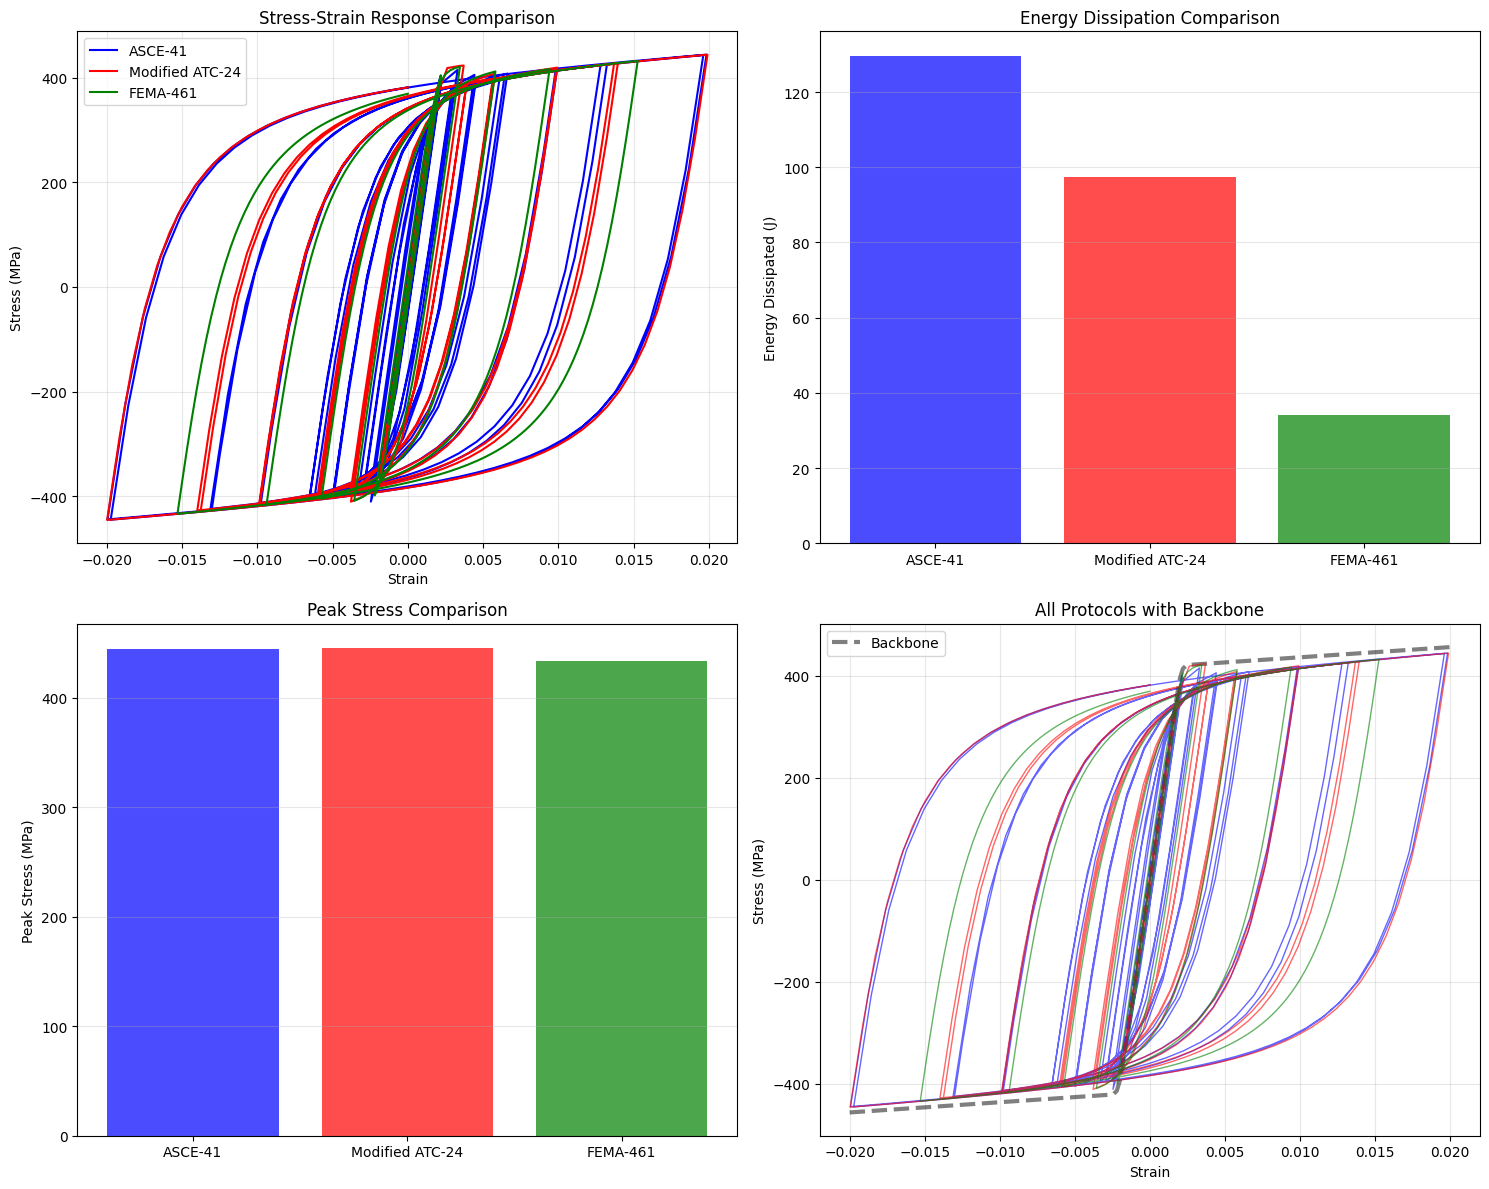

Saved: asce-41_result.npz
Saved: modified_atc-24_result.npz
Saved: fema-461_result.npz


In [9]:
from apeSees.materials import Material
from apeSees.timeseries import ASCE41Protocol, ModifiedATC24Protocol, FEMA461Protocol
import matplotlib.pyplot as plt
import numpy as np

steel = Material("Steel02", 1, 420.0, 200000.0, 0.01, 20.0, 0.925, 0.15)

# Run multiple protocols
protocols_to_test = [
    (ASCE41Protocol(tag=1, max_disp=0.02), 'ASCE-41', 'blue'),
    (ModifiedATC24Protocol(tag=2, max_disp=0.02), 'Modified ATC-24', 'red'),
    (FEMA461Protocol(tag=3, max_disp=0.02, alpha=0.62), 'FEMA-461', 'green'),
]

results = []
for ts, label, _ in protocols_to_test:
    result = steel.tester.run(ts, number_of_points=500)
    results.append((result, label))
    print(f"\n{label} Results:")
    print(f"  Converged: {result.converged}")
    print(f"  Peak stress: {result.peak_stress:.2f} MPa")
    print(f"  Peak strain: {result.peak_strain:.4f}")
    print(f"  Energy dissipated: {result.energy_dissipated:.2e} J")

# Create summary comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Stress-strain curves
ax1 = axes[0, 0]
for (result, label), (_, _, color) in zip(results, protocols_to_test):
    ax1.plot(result.strain, result.stress, label=label, color=color, linewidth=1.5)
ax1.set_xlabel('Strain')
ax1.set_ylabel('Stress (MPa)')
ax1.set_title('Stress-Strain Response Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Energy dissipation bar chart
ax2 = axes[0, 1]
labels = [label for _, label in results]
energies = [result.energy_dissipated for result, _ in results]
colors = [color for _, _, color in protocols_to_test]
ax2.bar(labels, energies, color=colors, alpha=0.7)
ax2.set_ylabel('Energy Dissipated (J)')
ax2.set_title('Energy Dissipation Comparison')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Peak stress comparison
ax3 = axes[1, 0]
peak_stresses = [result.peak_stress for result, _ in results]
ax3.bar(labels, peak_stresses, color=colors, alpha=0.7)
ax3.set_ylabel('Peak Stress (MPa)')
ax3.set_title('Peak Stress Comparison')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Backbone overlay
ax4 = axes[1, 1]
backbone_result = steel.tester.get_backbone(strain_max=0.02, strain_min=-0.02, number_of_points=100)
ax4.plot(backbone_result.strain, backbone_result.stress, 
         'k--', linewidth=3, label='Backbone', alpha=0.5)
for (result, label), (_, _, color) in zip(results, protocols_to_test):
    ax4.plot(result.strain, result.stress, color=color, linewidth=1, alpha=0.6)
ax4.set_xlabel('Strain')
ax4.set_ylabel('Stress (MPa)')
ax4.set_title('All Protocols with Backbone')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save all results
for i, (result, label) in enumerate(results):
    filename = f"{label.replace(' ', '_').lower()}_result.npz"
    result.save(filename)
    print(f"Saved: {filename}")